## Imports


In [2]:
!conda activate base
!pip install torch
!pip install torchvision


In [4]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import onnx

## Hyper Parameters

In [12]:
batch_size = 16  # Smaller batch size
learning_rate = 0.001
num_epochs = 30
train_split = 0.8  # 80% for training, 20% for testing


## Data Augmentation

In [13]:
# load data and apply initial transform
dataset_path = 'Soil Data'
dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.ToTensor())

# data augmentation
augmentation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
])
dataset.transform = augmentation

# split dataset
train_size = int(train_split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model


In [14]:
# define CNN model
class SandNet(nn.Module):
    def __init__(self):
        super(SandNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 5) 

    def forward(self, x):
        x = nn.MaxPool2d(2)(nn.ReLU()(self.conv1(x)))
        x = nn.MaxPool2d(2)(nn.ReLU()(self.conv2(x)))
        x = nn.MaxPool2d(2)(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# init model and optimizer
model = SandNet()
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()

In [15]:
# Average soil compositions for each class in terms of
#        [sand, silt, clay]
soil_compositions = {
    "clay": [0, 0, 100],
    "silt": [0, 100, 0],
    "sand": [100, 0, 0],
    "silt loam": [0, 70, 30],
    "sandy loam": [70, 0, 30],
    "loam": [40, 40, 20],
    "sandy clay": [45, 0, 55],
    "silty clay": [0, 45, 55],
    "sandy clay loam": [58, 10, 32],
    "silty clay loam": [10, 58, 32]
}

softmax = nn.Softmax(dim=1)

## Train model


In [16]:

epoch_losses = []
epoch_accuracies = []

# train model
for epoch in range(num_epochs):
    running_loss = 0.0  
    correct, total = 0,0

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # accumulate running loss
        running_loss += loss.item()
        
        # accumulate correct predictions for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # calculate and store average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)
    
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")




Epoch 1 - Loss: 1.1666, Accuracy: 55.66%
Epoch 2 - Loss: 0.9659, Accuracy: 62.39%
Epoch 3 - Loss: 0.8145, Accuracy: 69.11%
Epoch 4 - Loss: 0.7727, Accuracy: 71.25%
Epoch 5 - Loss: 0.6838, Accuracy: 75.84%
Epoch 6 - Loss: 0.6866, Accuracy: 72.78%
Epoch 7 - Loss: 0.5314, Accuracy: 81.96%
Epoch 8 - Loss: 0.5516, Accuracy: 77.98%
Epoch 9 - Loss: 0.5936, Accuracy: 76.45%
Epoch 10 - Loss: 0.4081, Accuracy: 85.32%
Epoch 11 - Loss: 0.3911, Accuracy: 85.93%
Epoch 12 - Loss: 0.3427, Accuracy: 87.77%
Epoch 13 - Loss: 0.4082, Accuracy: 86.24%
Epoch 14 - Loss: 0.3680, Accuracy: 88.07%
Epoch 15 - Loss: 0.3255, Accuracy: 89.91%
Epoch 16 - Loss: 0.2539, Accuracy: 88.99%
Epoch 17 - Loss: 0.2390, Accuracy: 90.83%
Epoch 18 - Loss: 0.3253, Accuracy: 87.77%
Epoch 19 - Loss: 0.2326, Accuracy: 92.66%
Epoch 20 - Loss: 0.1845, Accuracy: 94.80%
Epoch 21 - Loss: 0.2036, Accuracy: 92.05%
Epoch 22 - Loss: 0.1686, Accuracy: 93.88%
Epoch 23 - Loss: 0.1532, Accuracy: 95.41%
Epoch 24 - Loss: 0.1096, Accuracy: 96.64%
E

## Plot 

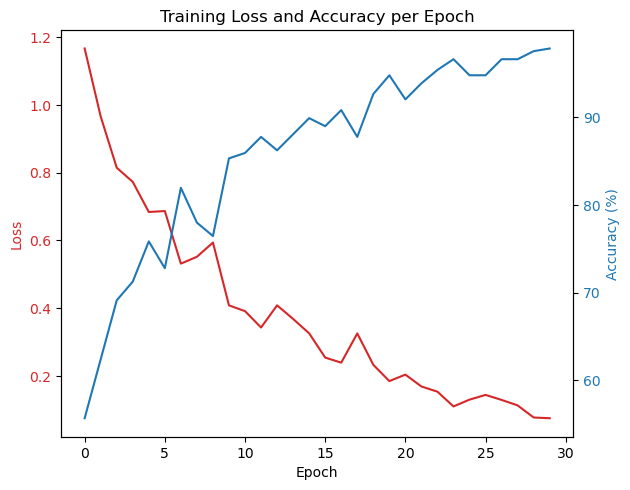

In [17]:
# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epoch_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(epoch_accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Accuracy per Epoch')
plt.show()

## Eval model

In [18]:
# evaluate model
def evaluate(loader):
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# print results
print(f"Training accuracy: {evaluate(train_loader)}%")
print(f"Testing accuracy: {evaluate(test_loader)}%")

Training accuracy: 96.94189602446484%
Testing accuracy: 84.14634146341463%


In [19]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    # Apply the same transformations as you did for your training set
    image_tensor = augmentation(image).unsqueeze(0)  # Add a batch dimension
    return image_tensor

def get_model_output(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        outputs = model(image_tensor)
    return outputs

def predict_composition(outputs):
    # Get softmax probabilities
    probabilities = nn.Softmax(dim=1)(outputs).detach().numpy()[0]  # Assuming outputs is a batch of size 1
    
    # Calculate average soil composition based on model predictions
    avg_composition = np.zeros(3)
    for i, class_name in enumerate(dataset.classes):  # Assuming 'dataset' is your ImageFolder dataset
        class_composition = np.array(soil_compositions[class_name])
        avg_composition += probabilities[i] * class_composition
    
    return avg_composition


In [20]:
if __name__ == "__main__":
    image_path = input("Enter the path of the image: ")  # User inputs the image path
    outputs = get_model_output(image_path)
    composition = predict_composition(outputs)
    print(f"Predicted soil composition [sand, silt, clay]: {composition}")


NameError: name 'Image' is not defined